In [ ]:
import numpy as np # linear algebra
import pandas as pd # processing data 
import matplotlib.pyplot as plt 
import seaborn as sns # visualization tool
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Course Resolution


In recommender systems, considering a matrix of user ratings for movies, matrix factorisation infers the latent characteristics of the movies and the affinity of users for each of them. Applications include signal decomposition, where a matrix of signals is decomposed into a set of base components along with a mixing matrix.  This lower rank approximation relies on an approximation of the latent factors and thus offers an insight on the problem.

The dataset here is a sample of the transactions made in a retail store. The store wants to know better the customer purchase behaviour against different products. Specifically, here the problem is a regression problem where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables.

Classification problem can also be settled in this dataset since several variables are categorical, and some other approaches could be "Predicting the age of the consumer" or even "Predict the category of goods bought". This dataset is also particularly convenient for clustering and maybe find different clusters of consumers within it.


# Resolution 1: The gradient descent

The simplest way to compute the matrices $\mathbf{P}$ and $\mathbf{Q}$ is to use a gradient descent. It consists in initializing the estimated matrices randomly, compute their difference to the real data, and follow the gradient of the values to reach a minimum.

I this exercise, we will consider a divergence based on the Euclidean distance: the Frobenius norm:

$$\min_{\mathbf{P}, \mathbf{Q} > 0} \| \mathbf{R} - \mathbf{P} \cdot \mathbf{Q}^\top\|^2_F$$


## The Squared Error

The goal here is to minimize the reconstruction error. The first step is to compute this error. Write below a function that computes the formula for this error given $\mathbf{R}$, $\mathbf{P}$, $\mathbf{Q}$ and two indices $i$ and $j$:
    

In [4]:
dataset = pd.read_csv('BlackFriday.csv')
dataset.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
# remove NaN values and set it to 0
dataset.Product_Category_2.fillna(0, inplace=True)
dataset.Product_Category_3.fillna(0, inplace=True)

dataset.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [6]:
# Categorised String data like City_Category, Age and Gender to numeric data
dataset['City_Category'] = dataset['City_Category'].astype('category').cat.codes
dataset['Age'] = dataset['Age'].astype('category').cat.codes
dataset['Gender'] = dataset['Gender'].astype('category').cat.codes
dataset['Stay_In_Current_City_Years'] = dataset['Stay_In_Current_City_Years'].astype('category').cat.codes
dataset.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,0,0,10,0,2,0,3,0.0,0.0,8370
1,1000001,P00248942,0,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,P00087842,0,0,10,0,2,0,12,0.0,0.0,1422
3,1000001,P00085442,0,0,10,0,2,0,12,14.0,0.0,1057
4,1000002,P00285442,1,6,16,2,4,0,8,0.0,0.0,7969


In [7]:
# Separated input(X) and output(Y)
X = dataset.iloc[:, 2:-1]
Y = dataset.iloc[:, 11]
x_train = np.asarray(X)
Y_train = np.asarray(Y)
y_train = Y_train.reshape(537577,1)
print(x_train.shape)
print(y_train.shape)

(537577, 9)
(537577, 1)


In [8]:
print (X.dtypes)


Gender                           int8
Age                              int8
Occupation                      int64
City_Category                    int8
Stay_In_Current_City_Years       int8
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
dtype: object


In [9]:
def  cal_cost(theta,X,y):
    '''
    
    Calculates the cost for given X and Y. The following shows and example of a single dimensional X
    theta = Vector of thetas 
    X     = Row of X's np.zeros((2,j))
    y     = Actual y's np.zeros((2,1))
    
    where:
        j is the no of features
    '''
    
    m = len(y)
    
    predictions = X.dot(theta)
    cost = (1/2*m) * np.sum(np.square(predictions-y))
    return cost

In [10]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=200):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,10))
    for it in range(iterations):
        
        prediction = np.dot(X,theta)
        
        
        theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
        theta_history[it,:] =theta.T
        cost_history[it]  = cal_cost(theta,X,y)
        
    return theta, cost_history, theta_history

In [11]:
lr =0.01
n_iter = 2000

theta = np.random.randn(10,1)

X_b = np.c_[np.ones((len(x_train),1)),x_train]
theta,cost_history,theta_history = gradient_descent(X_b,y_train,theta,lr,n_iter)




In [12]:
print('Theta0:          {:0.3f},\nTheta1:          {:0.3f},\nTheta2:        {:0.3f}'.format(theta[0][0],theta[1][0],theta[2][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

Theta0:          -9977512.439,
Theta1:          -7705178.058,
Theta2:        -25709150.063
Final cost/MSE:  702033311615337182151980351488.000


In [13]:
print(theta)

[[-9.97751244e+06]
 [-7.70517806e+06]
 [-2.57091501e+07]
 [-1.02849532e+08]
 [-1.05833147e+07]
 [-1.88588126e+07]
 [-4.16213638e+06]
 [-5.40415278e+07]
 [-8.47871017e+07]
 [-4.71664605e+07]]


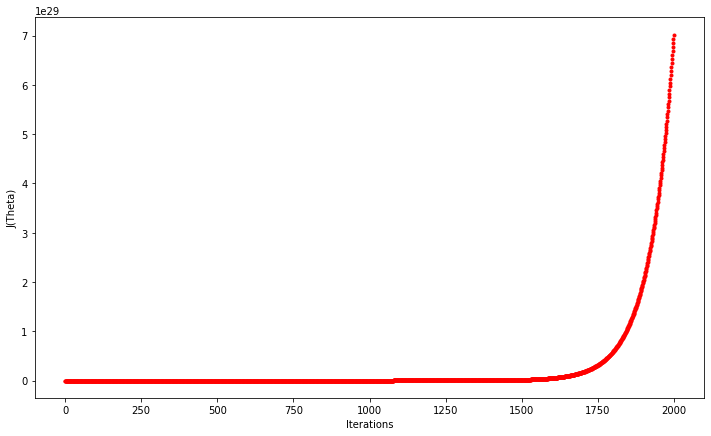

In [14]:
fig,ax = plt.subplots(figsize=(12,7))

ax.set_ylabel('J(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),cost_history,'r.')

In [15]:
def stocashtic_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    
    
    for it in range(iterations):
        cost =0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

In [16]:
lr =0.5
n_iter = 50

theta = np.random.randn(10,1)

X_b = np.c_[np.ones((len(x_train),1)),x_train]
theta,cost_history = stocashtic_gradient_descent(X_b,y_train,theta,lr,n_iter)


print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

Final cost/MSE:  5845686526644.044


In [17]:
print(theta)

[[7395.73197047]
 [1120.96575746]
 [ 225.02710298]
 [  13.78117197]
 [ 519.44481679]
 [ 130.93373917]
 [  42.1060441 ]
 [-256.1177626 ]
 [  24.40226359]
 [ 172.16976877]]


In [ ]:
fig,ax = plt.subplots(figsize=(12,8))

ax.set_ylabel('J(Theta)')
ax.set_xlabel('Iterations')
_=ax.plot(range(n_iter),cost_history,'b.')

In [ ]:
def minibatch_gradient_descent(X,y,theta,learning_rate=0.01,iterations=10,batch_size =20):
    '''
    X    = Matrix of X without added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    n_batches = int(m/batch_size)
    
    for it in range(iterations):
        cost =0.0
        indices = np.random.permutation(m)
        X = X[indices]
        y = y[indices]
        for i in range(0,m,batch_size):
            X_i = X[i:i+batch_size]
            y_i = y[i:i+batch_size]
            
            X_i = np.c_[np.ones(len(X_i)),X_i]
           
            prediction = np.dot(X_i,theta)

            theta = theta -(1/m)*learning_rate*( X_i.T.dot((prediction - y_i)))
            cost += cal_cost(theta,X_i,y_i)
        cost_history[it]  = cost
        
    return theta, cost_history

In [ ]:
lr =0.1
n_iter = 200

theta = np.random.randn(10,1)


theta,cost_history = minibatch_gradient_descent(x_train,y_train,theta,lr,n_iter)


#print('Theta0:          {:0.3f},\nTheta1:          {:0.3f}'.format(theta[0][0],theta[1][0]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))


In [ ]:
print('Theta values :  ', theta)

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))

ax.set_ylabel('{J(Theta)}',rotation=0)
ax.set_xlabel('{Iterations}')
theta = np.random.randn(2,1)

_=ax.plot(range(n_iter),cost_history,'b.')
